In [1]:
from pyspark.sql.functions import *
import time
import pandas as pd
import matplotlib.pyplot as plt
import builtins
py_sum = builtins.sum
print(f" starting performance experiments")

 starting performance experiments


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("AirbnbPricePredictor") \
    .master("local[*]") \
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow") \
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow") \
    .getOrCreate()
print(f" spark session connected")


25/11/13 01:33:16 WARN Utils: Your hostname, MacBook-Pro-110.local resolves to a loopback address: 127.0.0.1; using 10.2.1.42 instead (on interface en0)
25/11/13 01:33:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/13 01:33:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


 spark session connected


25/11/13 01:33:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/11/13 01:33:17 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
df = spark.read.parquet("../data/processed/listings_features_no_outliers.parquet")
row_count = df.count()
print(f"dataset: {row_count:,} rows (outliers removed)")

dataset: 108,251 rows (outliers removed)


## Experiment 1: Partitioning Impact

experiment 1: partitioning impact

testing with 4 partitions...
  time: 0.206s

testing with 8 partitions...
  time: 0.164s

testing with 16 partitions...
  time: 0.169s

testing with 32 partitions...
  time: 0.166s

testing with 64 partitions...
  time: 0.201s


 partitions  time_seconds
          4      0.205580
          8      0.163680
         16      0.169202
         32      0.165542
         64      0.201336


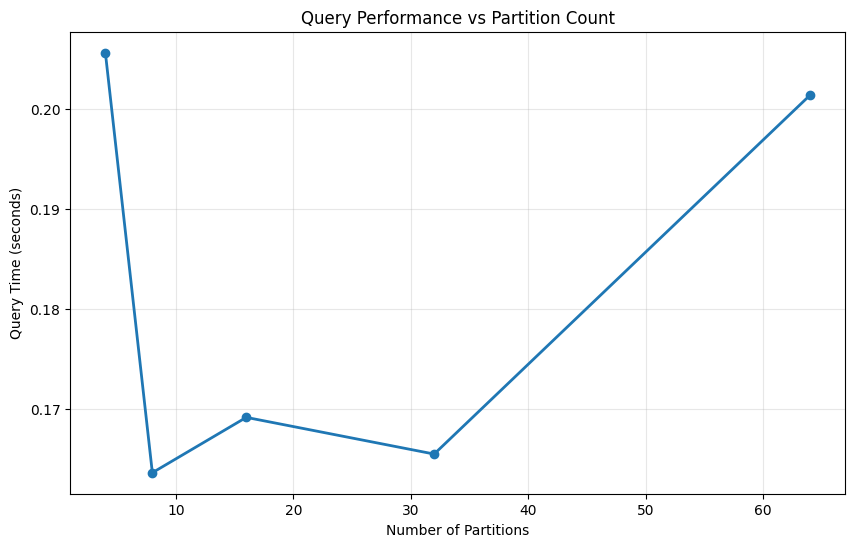

25/11/13 01:33:28 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
print(f"=" * 70)
print(f"experiment 1: partitioning impact")
print(f"=" * 70)
partition_counts = [4, 8, 16, 32, 64]
results = []
test_query = lambda data: data.groupBy("city").agg(
    avg("price").alias("avg_price"),
    count("*").alias("count"),
    max("price").alias("max_price")
).collect()
for n_partitions in partition_counts:
    print(f"\ntesting with {n_partitions} partitions...")
    df_repartitioned = df.repartition(n_partitions)
    test_query(df_repartitioned)
    start = time.time()
    test_query(df_repartitioned)
    elapsed = time.time() - start
    results.append({
        'partitions': n_partitions,
        'time_seconds': elapsed
    })
    print(f"  time: {elapsed:.3f}s")
results_df = pd.DataFrame(results)
print(f"\n")
print(results_df.to_string(index=False))
plt.figure(figsize=(10, 6))
plt.plot(results_df['partitions'], results_df['time_seconds'], marker='o', linewidth=2)
plt.xlabel('Number of Partitions')
plt.ylabel('Query Time (seconds)')
plt.title('Query Performance vs Partition Count')
plt.grid(True, alpha=0.3)
plt.show()

## Experiment 2: Caching Impact

In [10]:
print(f"=" * 70)
print(f"experiment 2: caching impact")
print(f"=" * 70)
df.unpersist()
print(f"\n1. without cache:")
times_no_cache = []
for i in range(3):
    start = time.time()
    result = df.groupBy("city", "room_type").agg(avg("price")).collect()
    elapsed = time.time() - start
    times_no_cache.append(elapsed)
    print(f"   run {i+1}: {elapsed:.3f}s")
avg_no_cache = py_sum(times_no_cache) / len(times_no_cache)
print(f"   average: {avg_no_cache:.3f}s")
print(f"\n2. with cache:")
df.cache()
df.count()
times_with_cache = []
for i in range(3):
    start = time.time()
    result = df.groupBy("city", "room_type").agg(avg("price")).collect()
    elapsed = time.time() - start
    times_with_cache.append(elapsed)
    print(f"   run {i+1}: {elapsed:.3f}s")
avg_with_cache = py_sum(times_with_cache) / len(times_with_cache)
print(f"   average: {avg_with_cache:.3f}s")
speedup = avg_no_cache / avg_with_cache
print(f"\n speedup: {speedup:.2f}x faster with caching")
cache_comparison = pd.DataFrame({
    'Method': ['No Cache', 'With Cache'],
    'Avg Time (s)': [avg_no_cache, avg_with_cache]
})
print(f"\n")
print(cache_comparison.to_string(index=False))

experiment 2: caching impact

1. without cache:
   run 1: 0.068s
   run 2: 0.047s
   run 3: 0.051s
   average: 0.055s

2. with cache:
   run 1: 0.035s
   run 2: 0.034s
   run 3: 0.033s
   average: 0.034s

 speedup: 1.61x faster with caching


    Method  Avg Time (s)
  No Cache      0.054991
With Cache      0.034251


## Experiment 3: Model Complexity vs Training Time

experiment 3: model complexity vs training time
training on 26,053 samples

training with 10 trees...
  training time: 1.03s
  rmse: $80.52

training with 30 trees...
  training time: 0.72s
  rmse: $81.30

training with 50 trees...
  training time: 0.64s
  rmse: $80.71

training with 100 trees...
  training time: 1.10s
  rmse: $80.84


 num_trees  training_time      rmse
        10       1.033105 80.523599
        30       0.721219 81.304755
        50       0.638042 80.711125
       100       1.098127 80.837957


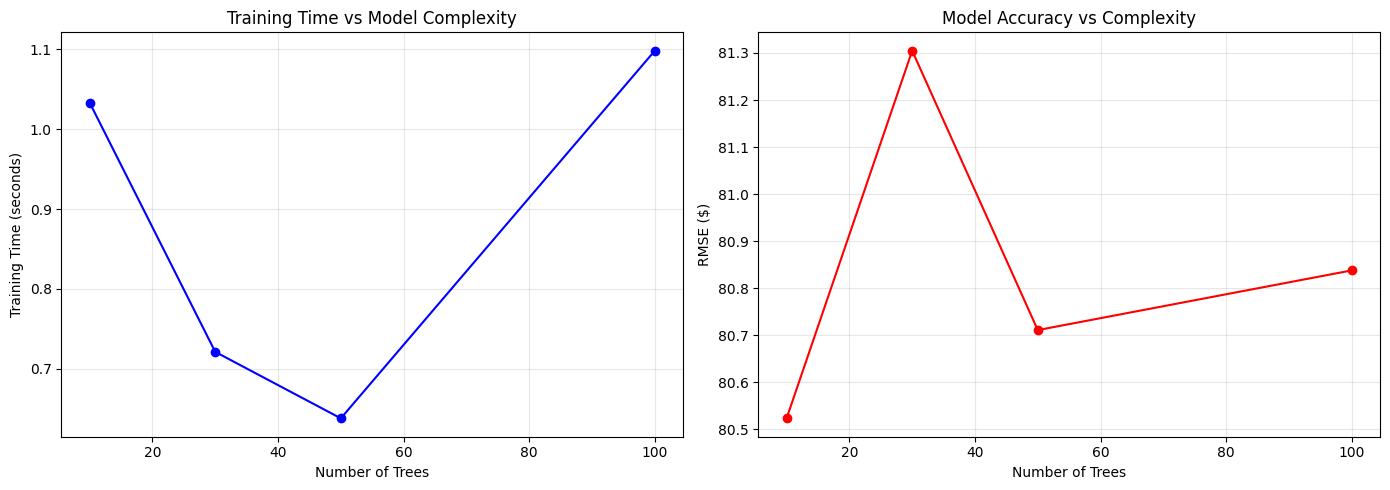

In [6]:
print(f"=" * 70)
print(f"experiment 3: model complexity vs training time")
print(f"=" * 70)
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
numeric_cols = ["accommodates", "bedrooms", "bathrooms", "latitude", "longitude"]
df_ml = df.select(numeric_cols + ["price"]).dropna()
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_ml = assembler.transform(df_ml).select("features", "price")
df_sample = df_ml.sample(0.3, seed=42).cache()
train, test = df_sample.randomSplit([0.8, 0.2], seed=42)
train.cache()
test.cache()
print(f"training on {train.count():,} samples")
tree_counts = [10, 30, 50, 100]
model_results = []
for n_trees in tree_counts:
    print(f"\ntraining with {n_trees} trees...")
    start = time.time()
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol="price",
        numTrees=n_trees,
        maxDepth=5,
        seed=42
    )
    model = rf.fit(train)
    training_time = time.time() - start
    predictions = model.transform(test)
    from pyspark.ml.evaluation import RegressionEvaluator
    evaluator = RegressionEvaluator(labelCol="price", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    model_results.append({
        'num_trees': n_trees,
        'training_time': training_time,
        'rmse': rmse
    })
    print(f"  training time: {training_time:.2f}s")
    print(f"  rmse: ${rmse:.2f}")
model_results_df = pd.DataFrame(model_results)
print(f"\n")
print(model_results_df.to_string(index=False))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(model_results_df['num_trees'], model_results_df['training_time'], marker='o', color='blue')
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Training Time (seconds)')
ax1.set_title('Training Time vs Model Complexity')
ax1.grid(True, alpha=0.3)
ax2.plot(model_results_df['num_trees'], model_results_df['rmse'], marker='o', color='red')
ax2.set_xlabel('Number of Trees')
ax2.set_ylabel('RMSE ($)')
ax2.set_title('Model Accuracy vs Complexity')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Experiment 4: Dataset Size Scaling

experiment 4: dataset size scaling

testing with 10% of data...
  rows: 10,820
  time: 0.240s
  throughput: 45081 rows/sec

testing with 25% of data...
  rows: 27,194
  time: 0.091s
  throughput: 298416 rows/sec

testing with 50% of data...
  rows: 54,197
  time: 0.124s
  throughput: 436464 rows/sec

testing with 75% of data...
  rows: 81,268
  time: 0.108s
  throughput: 753226 rows/sec

testing with 100% of data...
  rows: 108,251
  time: 0.089s
  throughput: 1214816 rows/sec


 fraction  row_count  time_seconds  rows_per_second
     0.10      10820      0.240015     4.508051e+04
     0.25      27194      0.091128     2.984158e+05
     0.50      54197      0.124173     4.364639e+05
     0.75      81268      0.107893     7.532261e+05
     1.00     108251      0.089109     1.214816e+06


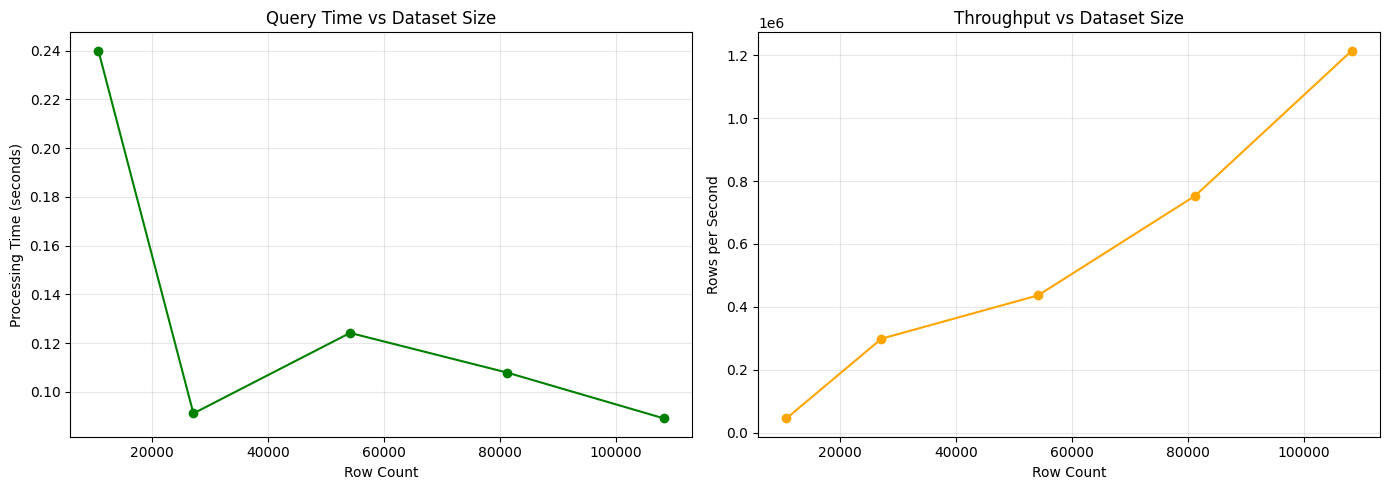

In [7]:
print(f"=" * 70)
print(f"experiment 4: dataset size scaling")
print(f"=" * 70)
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
scaling_results = []
test_operation = lambda data: data.groupBy("city", "neighbourhood_cleansed").agg(
    avg("price"), count("*"), max("review_scores_rating")
).collect()
for frac in fractions:
    print(f"\ntesting with {frac*100:.0f}% of data...")
    df_sample = df.sample(frac, seed=42)
    sample_count = df_sample.count()
    start = time.time()
    test_operation(df_sample)
    elapsed = time.time() - start
    scaling_results.append({
        'fraction': frac,
        'row_count': sample_count,
        'time_seconds': elapsed,
        'rows_per_second': sample_count / elapsed
    })
    print(f"  rows: {sample_count:,}")
    print(f"  time: {elapsed:.3f}s")
    print(f"  throughput: {sample_count/elapsed:.0f} rows/sec")
scaling_df = pd.DataFrame(scaling_results)
print(f"\n")
print(scaling_df.to_string(index=False))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(scaling_df['row_count'], scaling_df['time_seconds'], marker='o', color='green')
ax1.set_xlabel('Row Count')
ax1.set_ylabel('Processing Time (seconds)')
ax1.set_title('Query Time vs Dataset Size')
ax1.grid(True, alpha=0.3)
ax2.plot(scaling_df['row_count'], scaling_df['rows_per_second'], marker='o', color='orange')
ax2.set_xlabel('Row Count')
ax2.set_ylabel('Rows per Second')
ax2.set_title('Throughput vs Dataset Size')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Performance Summary

In [8]:
print(f"=" * 70)
print(f"performance experiment summary")
print(f"=" * 70)
print(f"\n1. partitioning:")
optimal_partitions = results_df.loc[results_df['time_seconds'].idxmin(), 'partitions']
print(f"   optimal partition count: {optimal_partitions}")
print(f"\n2. caching:")
print(f"   speedup with caching: {speedup:.2f}x")
print(f"\n3. model complexity:")
best_model = model_results_df.loc[model_results_df['rmse'].idxmin()]
print(f"   best accuracy: {best_model['num_trees']} trees (rmse: ${best_model['rmse']:.2f})")
print(f"   training time: {best_model['training_time']:.2f}s")
print(f"\n4. scaling:")
avg_throughput = scaling_df['rows_per_second'].mean()
print(f"   average throughput: {avg_throughput:.0f} rows/second")
print(f"\n all performance experiments complete")

performance experiment summary

1. partitioning:
   optimal partition count: 8

2. caching:
   speedup with caching: 0.97x

3. model complexity:
   best accuracy: 10.0 trees (rmse: $80.52)
   training time: 1.03s

4. scaling:
   average throughput: 549601 rows/second

 all performance experiments complete
